<a href="https://colab.research.google.com/github/bostankhan6/Image-Segmentation-Unet-DeepLabV3-Segnet/blob/master/Segnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%tensorflow_version 1.x
import tensorflow as tf
from keras.models import Model
from keras.layers import Activation,Input,ZeroPadding2D,Cropping2D,BatchNormalization,Conv2D
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import random

from keras.engine.topology import Layer
import keras.backend as K
from tqdm import tqdm_notebook, tnrange
import argparse

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.utils import multi_gpu_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import imageio
import numpy as np
from keras.utils import to_categorical
import os


TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
class MaxPoolingWithIndices(Layer):
    def __init__(self, pool_size,strides,padding='SAME',**kwargs):
        super(MaxPoolingWithIndices, self).__init__(**kwargs)
        self.pool_size=pool_size
        self.strides=strides
        self.padding=padding
        return
    def call(self,x):
        pool_size=self.pool_size
        strides=self.strides
        if isinstance(pool_size,int):
            ps=[1,pool_size,pool_size,1]
        else:
            ps=[1,pool_size[0],pool_size[1],1]
        if isinstance(strides,int):
            st=[1,strides,strides,1]
        else:
            st=[1,strides[0],strides[1],1]
        output1,output2=tf.nn.max_pool_with_argmax(x,ps,st,self.padding)#here
        return [output1,output2]
    def compute_output_shape(self, input_shape):
        if isinstance(self.pool_size,int):
            output_shape=(input_shape[0],input_shape[1]//self.pool_size,input_shape[2]//self.pool_size,input_shape[3])
        else:
            output_shape=(input_shape[0],input_shape[1]//self.pool_size[0],input_shape[2]//self.pool_size[1],input_shape[3])
        return [output_shape,output_shape]


class UpSamplingWithIndices(Layer):
    def __init__(self, **kwargs):
        super(UpSamplingWithIndices, self).__init__(**kwargs)
        return
    def call(self,x):
        argmax=K.cast(K.flatten(x[1]),'int32')
        max_value=K.flatten(x[0])
        with tf.variable_scope(self.name):
            input_shape=K.shape(x[0])
            batch_size=input_shape[0]
            image_size=input_shape[1]*input_shape[2]*input_shape[3]
            output_shape=[input_shape[0],input_shape[1]*2,input_shape[2]*2,input_shape[3]]
            indices_0=K.flatten(tf.matmul(K.reshape(tf.range(batch_size),(batch_size,1)),K.ones((1,image_size),dtype='int32')))
            indices_1=argmax%(image_size*4)//(output_shape[2]*output_shape[3])
            indices_2=argmax%(output_shape[2]*output_shape[3])//output_shape[3]
            indices_3=argmax%output_shape[3]
            indices=tf.stack([indices_0,indices_1,indices_2,indices_3])
            output=tf.scatter_nd(K.transpose(indices),max_value,output_shape)
            return output
    def compute_output_shape(self, input_shape):
        return input_shape[0][0],input_shape[0][1]*2,input_shape[0][2]*2,input_shape[0][3]

def CompositeConv(inputs,num_layers,num_features):
    output=inputs
    if isinstance(num_features,int):
        for i in range(num_layers):
            output=Conv2D(num_features,(7,7),padding='same')(output)
            output=BatchNormalization(axis=3)(output)
            output=Activation('relu')(output)
        return output
    for i in range(num_layers):
        output=Conv2D(num_features[i],(7,7),padding='same')(output)
        output=BatchNormalization(axis=3)(output)
        output=Activation('relu')(output)
    return output

In [0]:
def create_model(image_shape = (256,256,3), num_classes=1):
    inputs=Input(shape=image_shape)

    #x = ZeroPadding2D(padding)(inputs)

    x=CompositeConv(inputs,2,64)
    x,argmax1=MaxPoolingWithIndices(pool_size=2,strides=2)(x)
    
    x=CompositeConv(x,2,64)
    x,argmax2=MaxPoolingWithIndices(pool_size=2,strides=2)(x)
    
    x=CompositeConv(x,3,64)
    x,argmax3=MaxPoolingWithIndices(pool_size=2,strides=2)(x)

    x=CompositeConv(x,3,64)
    x,argmax4=MaxPoolingWithIndices(pool_size=2,strides=2)(x)

    x=CompositeConv(x,3,64)
    x,argmax5=MaxPoolingWithIndices(pool_size=2,strides=2)(x)

    x=UpSamplingWithIndices()([x,argmax5])
    x=CompositeConv(x,3,64)

    x=UpSamplingWithIndices()([x,argmax4])
    x=CompositeConv(x,3,64)

    x=UpSamplingWithIndices()([x,argmax3])
    x=CompositeConv(x,3,64)

    x=UpSamplingWithIndices()([x,argmax2])
    x=CompositeConv(x,2,64)
    
    x=UpSamplingWithIndices()([x,argmax1])
    x=CompositeConv(x,2,[64,num_classes])

    x=Activation('sigmoid')(x)

    #y=Cropping2D(padding)(x)
    my_model=Model(inputs=inputs,outputs=x)
    
    return my_model

In [0]:
!cp -r /content/drive/My\ Drive/A3-Datasets/MonuSeg /content

## Setting Parameters and Loading Data

In [0]:
"""
Used to patchify the dataset of Semantic Segmentation
Set the directory for the current dataset, be sure to change the parameters.
Give new Dataset Dir, also specify the sub directories.
Patch size and Stride can be changed.
"""
import os
from skimage.io import imread, imsave
from skimage.util.shape import view_as_windows

# Parameters to change.
curr_dataset_dir = "MonuSeg/"
new_dataset_dir = "patched_MonuSeg/"

sub_dirs = ["Training/TissueImages/", "Training/GroundTruth/",
             "Test/TissueImages/", "Test/GroundTruth/"]
patch_size = {'rgb': (256,256, 3), 'grayscale': (256,256)}
stride = {'rgb': (256//2, 256//2, 3), 'grayscale': (256//2, 256//2)}

# Create the new dataset directory
os.makedirs(new_dataset_dir, exist_ok=True)

for sub_dir in sub_dirs:
    new_dir_ = new_dataset_dir + sub_dir
    # Create sub_dir in the new dataset directory
    os.makedirs(new_dir_, exist_ok=True)
    dir_ = curr_dataset_dir + sub_dir
    ids = next(os.walk(dir_))[2]

    for id_ in ids:
        img = imread(dir_ + id_)
        img_type = 'rgb' if img.ndim == 3 else 'grayscale'
        new_imgs = view_as_windows(img, patch_size[img_type], stride[img_type])
        new_imgs = new_imgs.reshape(-1, 256, 256, 3) if img.ndim == 3 else new_imgs.reshape(-1, 256, 256)
        for i, patch in enumerate(new_imgs):
            file_name, extension = id_.split('.')
            new_file_name = file_name + f'-PCH{i}.' + extension
            imsave(new_dir_ + new_file_name, patch)

In [0]:
"""
This function can be used to read the images from the dataset created by the patchify_dataset.py.
Example Usage:
X, y = get_images("ModMonuSeg/Training/", (im_width, im_height))
"""
def get_images(parent_dir, im_shape, img_folder="TissueImages/", gt_folder="GroundTruth/", gt_extension=None):
  tissue_dir = parent_dir + img_folder
  gt_dir = parent_dir + gt_folder

  im_width, im_height = im_shape


  ids = next(os.walk(tissue_dir))[2]
  print("No. of images = ", len(ids))

  X = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
  y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

  # tqdm is used to display the progress bar
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img(tissue_dir+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, 3), mode = 'constant', preserve_range = True)
    # Load masks
    mask_id_ = id_.split('.')[0]
    mask_id_ = '-'.join(id_.split('-')[:-1]) + '_bin_mask-'+ id_.split('-')[-1]
    if gt_extension:
      mask_id_ = mask_id_.split('.')[0] + '.' + gt_extension
    mask = img_to_array(load_img(gt_dir+mask_id_, grayscale=True))
    mask = resize(mask, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

  return X, y

In [0]:
train_parent_dir = '/content/patched_MonuSeg/Training/'
val_parent_dir = '/content/patched_MonuSeg/Test/'
im_shape = (256,256)
X_train, y_train = get_images(train_parent_dir, im_shape)


No. of images =  1080


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
X_test, y_test = get_images(val_parent_dir, im_shape, gt_extension='png')

No. of images =  504


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


#### Below code can be used to visualize the images and corresponding masks

Training Set Image

Text(0.5, 1.0, 'Ground Truth')

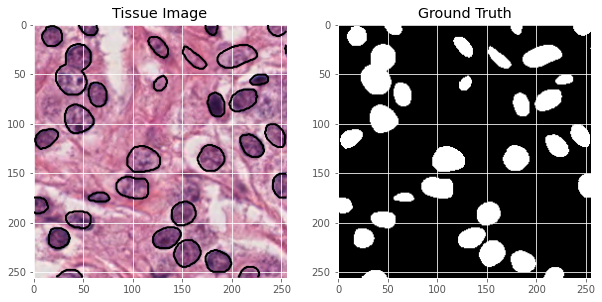

In [0]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))

ax1.imshow(X_train[ix])
if has_mask:
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 2, levels = [0.5])

ax1.set_title('Tissue Image')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Ground Truth')

# Defining the model

# Define the parametric functions



In [0]:
def dice_coef(y_true, y_pred):
  intersection = K.sum(y_true * y_pred, axis = (1,2,3))
  union = K.sum(y_true, axis = (1,2,3)) + K.sum(y_pred, axis = (1,2,3))
  return K.mean((2.0*intersection+1)/(union+1),axis = 0) 

In [0]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Getting the model and compiling

In [0]:
model=create_model()
model.compile('adam', loss="binary_crossentropy", metrics=["accuracy", dice_coef, f1_m])
model.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 256, 256, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 256, 256, 64) 256         conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 256, 256, 64) 0           batch_normalization_3[0][0]   

In [0]:
# Define the callbacks

callbacks = [
    EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=6, min_lr=0.000001, verbose=1),
    ModelCheckpoint('improved_unet_model.h5', verbose=1, save_weights_only=True, save_best_only=True, monitor='val_accuracy')
]

# Training the Model

In [0]:
results = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_split= 0.1
                    ,callbacks=callbacks)



Train on 972 samples, validate on 108 samples
Epoch 1/100
972/972 [==============================] - 78s 80ms/step - loss: 0.7014 - acc: 0.5271 - dice_coef: 0.3449 - f1_m: 0.2479 - val_loss: 0.6931 - val_acc: 0.7353 - val_dice_coef: 0.3363 - val_f1_m: 0.0000e+00
Epoch 2/100


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:707: RuntimeWarning: Can save best model only with val_accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


972/972 [==============================] - 63s 65ms/step - loss: 0.6931 - acc: 0.7259 - dice_coef: 0.3435 - f1_m: 8.8236e-04 - val_loss: 0.6931 - val_acc: 0.7353 - val_dice_coef: 0.3363 - val_f1_m: 0.0000e+00
Epoch 3/100
972/972 [==============================] - 63s 65ms/step - loss: 0.6931 - acc: 0.7260 - dice_coef: 0.3435 - f1_m: 0.0014 - val_loss: 0.6931 - val_acc: 0.7353 - val_dice_coef: 0.3363 - val_f1_m: 5.9672e-05
Epoch 4/100
972/972 [==============================] - 63s 65ms/step - loss: 0.6931 - acc: 0.7261 - dice_coef: 0.3435 - f1_m: 0.0052 - val_loss: 0.6932 - val_acc: 0.7344 - val_dice_coef: 0.3363 - val_f1_m: 0.0039
Epoch 5/100
972/972 [==============================] - 63s 65ms/step - loss: 0.6830 - acc: 0.7428 - dice_coef: 0.3655 - f1_m: 0.3822 - val_loss: 1.1500 - val_acc: 0.2759 - val_dice_coef: 0.4099 - val_f1_m: 0.4116
Epoch 6/100
972/972 [==============================] - 63s 65ms/step - loss: 0.6520 - acc: 0.8312 - dice_coef: 0.4199 - f1_m: 0.6767 - val_loss: 0.7

Saving the model and history files to drive

In [0]:
!cp /content/improved_unet_model.h5 /content/drive/My\ Drive/Models/ACV\ A3\ Models/Improved

In [0]:
import pickle
with open('/content/drive/My Drive/Models/ACV A3 weights/base_segnet_history', 'rb') as file_pi:
        history = pickle.load(file_pi)


# Plotting the Graphs

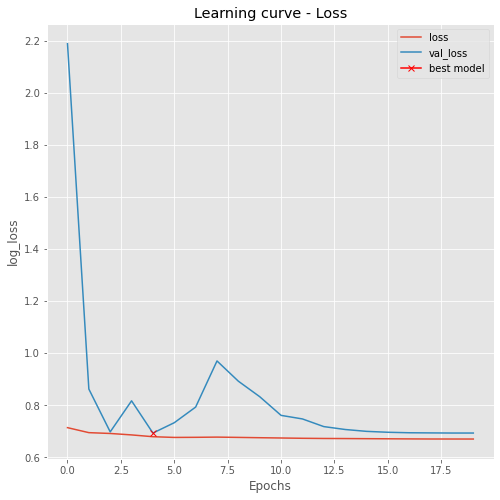

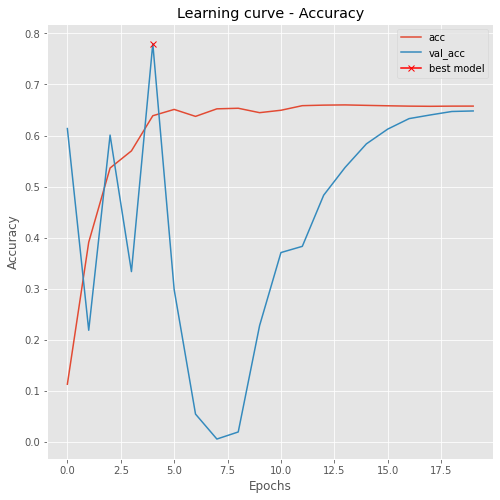

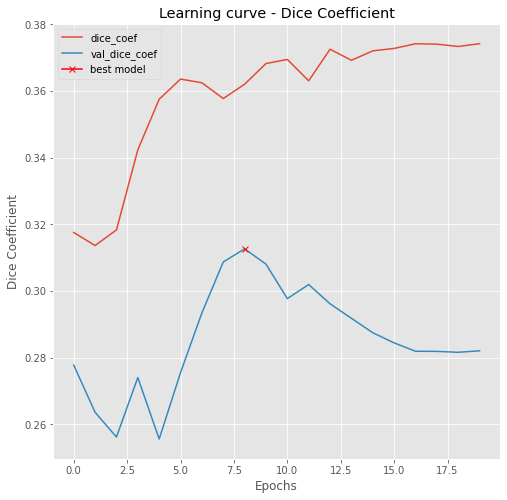

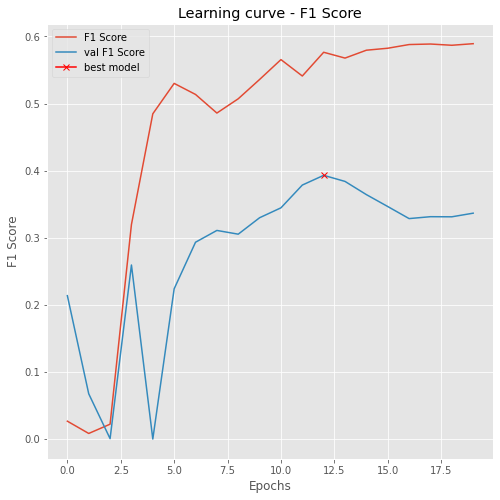

In [12]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve - Loss")
plt.plot(history["loss"], label="loss")
plt.plot(history["val_loss"], label="val_loss")
plt.plot( np.argmin(history["val_loss"]), np.min(history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize=(8, 8))
plt.title("Learning curve - Accuracy")
plt.plot(history["acc"], label="acc")
plt.plot(history["val_acc"], label="val_acc")
plt.plot( np.argmax(history["val_acc"]), np.max(history["val_acc"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

plt.figure(figsize=(8, 8))
plt.title("Learning curve - Dice Coefficient")
plt.plot(history["dice_coef"], label="dice_coef")
plt.plot(history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmax(history["val_dice_coef"]), np.max(history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend();

plt.figure(figsize=(8, 8))
plt.title("Learning curve - F1 Score")
plt.plot(history["f1_m"], label="F1 Score")
plt.plot(history["val_f1_m"], label="val F1 Score")
plt.plot( np.argmax(history["val_f1_m"]), np.max(history["val_f1_m"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend();

### Inference

In [0]:
# Evaluate on test set
model.evaluate(X_test, y_test, verbose=1)

504/504 [==============================] - 18s 36ms/step


[0.6813403982964773,
 0.8326013362596906,
 0.32255764045412577,
 0.579190607108767]

In [0]:
# Predict on train, val and test
preds_train = model.predict(X_train, batch_size = 1, verbose=1)
preds_val = model.predict(X_test, batch_size = 1, verbose=1)

504/504 [==============================] - 31s 61ms/step


In [0]:
# Out Thresholds on the the prediction to get either 1 or 0
preds_train_t = (preds_train > 0.5).astype(np.float32)
preds_val_t = (preds_val > 0.5).astype(np.float32)

Helper function for plotting the predictions

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
  #Arguments:
  #X: Train Set
  #y: ground truth Masks
  #preds: the predicted masks
  #binary_preds: the predicted masks after thresholding to 0 or 1
  #ix: if None, it will take a random sample. If provided with the index of the 
  #sample, it will plot that specific sample from tissue images
  
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X)-1)

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Ground Truth')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted binary');

### Visual predictions on training set

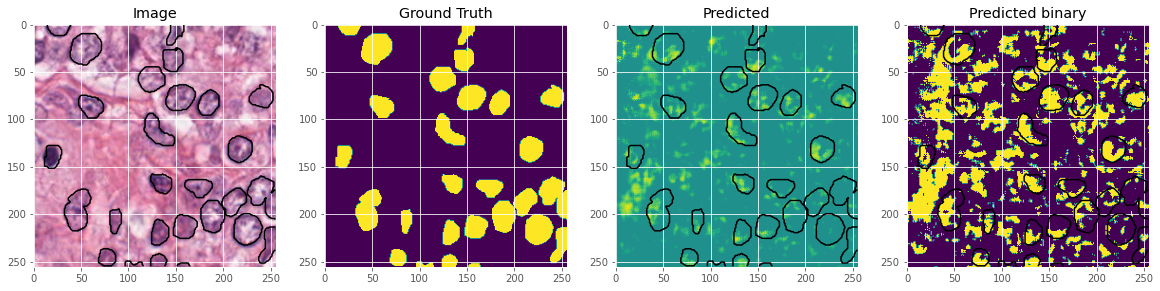

In [0]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

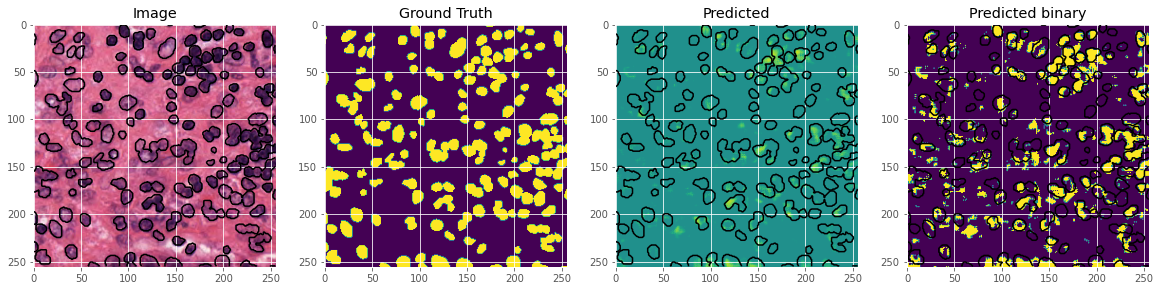

In [0]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

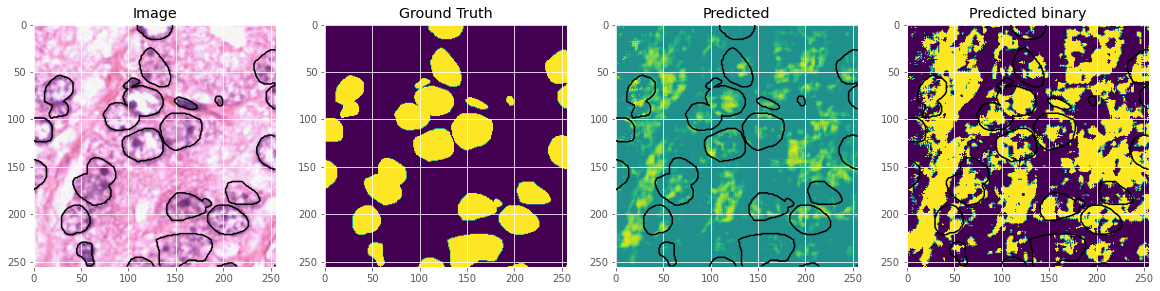

In [0]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

### Visual Predictions on test set

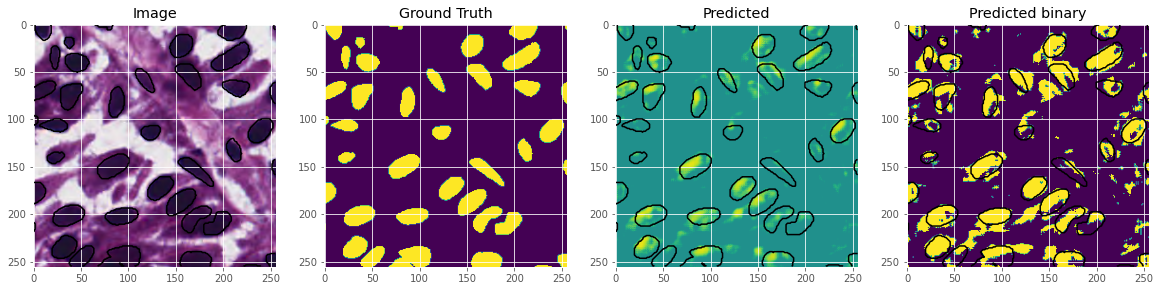

In [0]:
plot_sample(X_test, y_test, preds_val, preds_val_t)

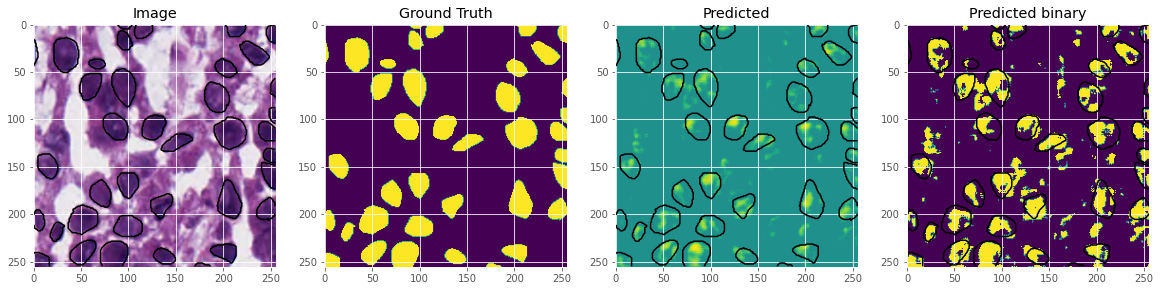

In [0]:
plot_sample(X_test, y_test, preds_val, preds_val_t)

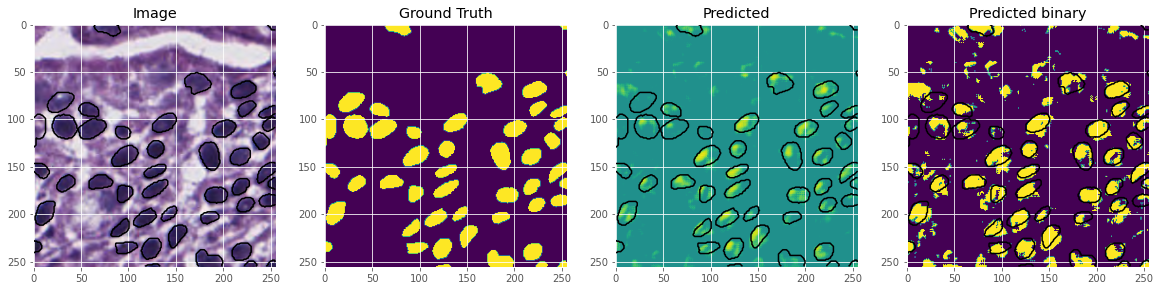

In [0]:
plot_sample(X_test, y_test, preds_val, preds_val_t)

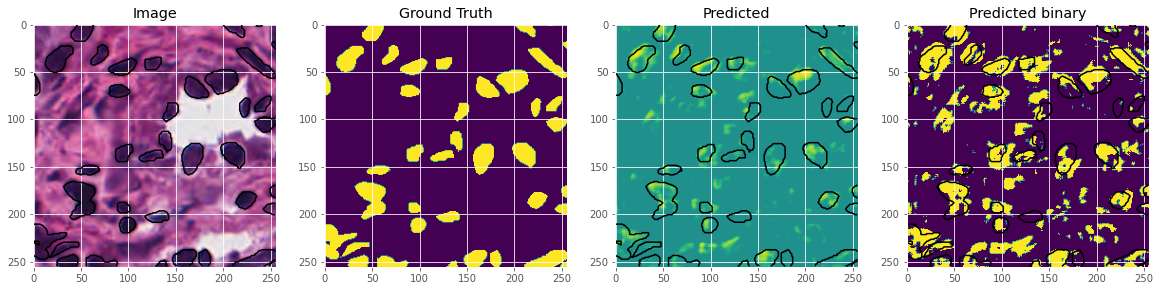

In [0]:
plot_sample(X_test, y_test, preds_val, preds_val_t)